In [2]:
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from transformers import AutoConfig, AutoTokenizer, AutoModel, BertConfig

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from train import draw_acc_curve, draw_loss_curve

In [5]:
from IPython import display
def rtl_print(outputs, font_size="15px", n_to_br=False):
    outputs = outputs if isinstance(outputs, list) else [outputs] 
    if n_to_br:
        outputs = [output.replace('\n', '') for output in outputs]
        
    outputs = [f'{output}' for output in outputs]
    display.display(display.HTML(' '.join(outputs)))


In [6]:
train_df = pd.read_csv('./data/FarsTail/data/Train-word.csv', sep='\t')
val_df = pd.read_csv('./data/FarsTail/data/Val-word.csv', sep='\t')
test_df = pd.read_csv('./data/FarsTail/data/Test-word.csv', sep='\t')

In [5]:
train_df.head()

,premise,hypothesis,label
0,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,نخستین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی...,e
1,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,کانون های جغرافیایی مصر، اندلس و شام، نخستین ر...,c
2,اولین انتقال و نفوذ طبیعی فرهنگ و تمدن اسلامی ...,سیسیل بعد از اسپانیا بزرگ ترین کانونی بود که ه...,n
3,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,نقاشی های تزئینی و تندیس های بی‌کیفیت، یکی از ...,e
4,ویژگی های هنر عصر اموی: ۱- تلفیقی بودن ۲- بازن...,با کیفیت بودن تندیس های دوره اموی، یکی از ویژگ...,c


In [7]:
train_df = train_df.sample(0.1)

ValueError: Only integers accepted as `n` values

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_df['label_id'] = label_encoder.fit_transform(train_df['label'])
val_df['label_id'] = label_encoder.transform(val_df['label'])
test_df['label_id'] = label_encoder.transform(test_df['label'])

In [8]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = 50

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # x = torch.tensor(row['text'], dtype=torch.float32)
        premise = row["premise"]
        hypothesis = row["hypothesis"]
        label = row["label"]
        label_id = row["label_id"]
        # text = f"{self.tokenizer.cls_token} {premise} {self.tokenizer.sep_token} {hypothesis} {self.tokenizer.sep_token}"
        # Tokenize inputs
        encoded_inputs = self.tokenizer.encode_plus(
            premise,
            hypothesis,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt",
        )
        input_ids = encoded_inputs["input_ids"].squeeze()
        attention_mask = encoded_inputs["attention_mask"].squeeze()
        token_type_id = encoded_inputs["token_type_ids"].squeeze()
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "token_type_ids": token_type_id,
            "label": label,
            "label_id": torch.tensor(label_id, dtype=torch.long),
        }

attention mask  
https://huggingface.co/transformers/v3.2.0/glossary.html#attention-mask  
token type id  
https://huggingface.co/transformers/v3.2.0/glossary.html#token-type-ids  

In [9]:

# config = AutoConfig.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
model = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")
# model = model.to(device)



Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
from multiprocessing import cpu_count

train_dataset = Dataset(train_df, tokenizer)
val_dataset = Dataset(val_df, tokenizer)
test_dataset = Dataset(test_df, tokenizer)


batch_size = 32
num_workers = cpu_count() - 2
pin_memory = True if device == "cuda" else False
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [10]:

config = AutoConfig.from_pretrained(
    "HooshvareLab/bert-base-parsbert-uncased"
)

In [11]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
import os
import numpy as np
from tqdm import tqdm

# from transformers import *
# from utils.utils import build_batch


class BertNLIModel(nn.Module):
    """Performs prediction, given the input of BERT embeddings."""

    def __init__(
        self,
        num_attention,
        model_path=None,
        label_num=3,
        reinit_num=0,
        freeze_layers=True,
    ):
        super(BertNLIModel, self).__init__()
        # self.bert = BertModel.from_pretrained('bert-base-uncased')
        # self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

        self.config = AutoConfig.from_pretrained(
            "HooshvareLab/bert-base-parsbert-uncased"
        )
        self.tokenizer = AutoTokenizer.from_pretrained(
            "HooshvareLab/bert-base-parsbert-uncased"
        )
        self.bert = AutoModel.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

        self.new_config = BertConfig(
            attention_probs_dropout_prob=self.config.attention_probs_dropout_prob,
            hidden_dropout_prob=self.config.hidden_dropout_prob,
            hidden_size=self.config.hidden_size,
            initializer_range=self.config.initializer_range,
            intermediate_size=self.config.intermediate_size,
            layer_norm_eps=self.config.layer_norm_eps,
            max_position_embeddings=self.config.max_position_embeddings,
            num_attention_heads=int(self.config.num_attention_heads / 2),  # Reduce the number of attention heads by half
            num_hidden_layers=self.config.num_hidden_layers,  # Reduce the number of hidden layers by half
            num_labels=self.config.num_labels,
            output_attentions=self.config.output_attentions,
            output_hidden_states=self.config.output_hidden_states,
            pad_token_id=self.config.pad_token_id,
            type_vocab_size=self.config.type_vocab_size,
            vocab_size=self.config.vocab_size
        )
    

        self.num_hidden_layers = self.config.num_hidden_layers
        self.vdim = self.config.hidden_size

        self.nli_head1 = nn.Linear(self.vdim, 250)
        self.nli_head2 = nn.Linear(250, label_num)
        self.sm = nn.Softmax(dim=1)
        self.reinit(layer_num=reinit_num, freeze=freeze_layers)

    def reinit(self, layer_num, freeze):
        """Reinitialise parameters of last N layers and freeze all others"""
        if freeze:
            for _, pp in self.bert.named_parameters():
                pp.requires_grad = False

    def forward(self, input_ids, attention_mask, token_type_ids):
        cls_vecs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_attentions=self.new_config.output_attentions,
            output_hidden_states=self.new_config.output_hidden_states,
        )[1]

        logits = self.nli_head1(cls_vecs)
        logits = self.nli_head2(logits)
        probs = self.sm(logits)

        torch.cuda.empty_cache()  # releases all unoccupied cached memory

        return logits, probs

    def _get_name(self):
        return f"{super()._get_name()}-head-{self.new_config.num_attention_heads}"

    def __str__(self) -> str:
        return f"BertNLIModel-Encoder-{self.new_config.num_attention_heads}"

    def __repr__(self):
        return f"BertNLIModel-Encoder-{self.new_config.num_attention_heads}"

In [11]:
config.num_attention_heads

12

# 50 %

In [12]:
num_attention = int(config.num_attention_heads / 2)
model = BertNLIModel(label_num=3, num_attention=num_attention)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4,eps=1e-6)

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model/state-BertNLIModel-head-6-optimizer-AdamW-loss-CrossEntropyLoss.pth exist


[37s] Epoch 26 loss : 0.97526053 acc: 51.23 val: 0.98563907 acc: 49.49%


### BETTER NET STATE ###
[50s] Epoch 27 loss : 0.97459611 acc: 51.57 val: 0.96639781 acc: 51.21%


[92s] Epoch 28 loss : 0.97178357 acc: 51.84 val: 0.96847961 acc: 50.9%


[199s] Epoch 29 loss : 0.96883854 acc: 51.54 val: 0.98249995 acc: 49.68%


[279s] Epoch 30 loss : 0.96942134 acc: 51.61 val: 1.00050926 acc: 47.57%


### BETTER NET STATE ###
[287s] Epoch 31 loss : 0.96993264 acc: 51.89 val: 0.96530478 acc: 52.62%


### BETTER NET STATE ###
[208s] Epoch 32 loss : 0.96878171 acc: 51.98 val: 0.96388867 acc: 52.24%


[111s] Epoch 33 loss : 0.96909940 acc: 51.76 val: 0.97590795 acc: 50.38%


### BETTER NET STATE ###
[105s] Epoch 34 loss : 0.96580752 acc: 52.11 val: 0.95788858 acc: 51.85%


### BETTER NET STATE ###
[103s] Epoch 35 loss : 0.96694548 acc: 51.9 val: 0.95684852 acc: 52.24%


### BETTER NET STATE ###
[94s] Epoch 36 loss : 0.96574820 acc: 51.71 val: 0.95616126 acc: 51.73%


### BETTER NET STATE ###
[87s] Epoch 37 loss : 0.96282846 acc: 51.91 val: 0.94824993 acc: 53.64%


[84s] Epoch 38 loss : 0.96377623 acc: 52.01 val: 0.95638381 acc: 51.79%


[83s] Epoch 39 loss : 0.96187497 acc: 52.59 val: 0.95289146 acc: 51.92%


[80s] Epoch 40 loss : 0.96157944 acc: 52.42 val: 0.95036226 acc: 53.01%


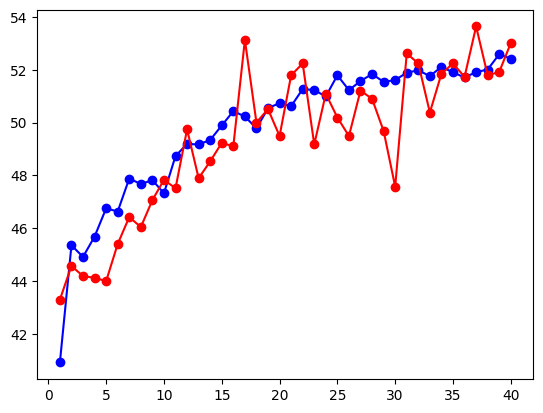

In [14]:
from train import train
from easydict import EasyDict

dataset = EasyDict(
    {
        "train": train_dataset,
        "val": test_dataset,
        "test": test_dataset,
    }
)
data_loader = EasyDict(
    {
        "train": train_loader,
        "val": test_loader,
        "test": test_loader,
    }
)



start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [ ]:

res = start['res']
draw_loss_curve(current_epoch=res['epoch'], net_name="BertNLI", optimizer_name="optim", loss_name="loss", res=res)
plt.legend()

In [ ]:

draw_acc_curve(current_epoch=res['epoch'], net_name="BertNLI", optimizer_name="optim", loss_name="loss", res=res)
plt.legend()

In [15]:

from tools import evaluate_loader, show_cm, plot_metrics, plot_cm
labels = label_encoder.transform(label_encoder.classes_)
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

loss 0.9498151942175261
accuracy 0.5301567055393587
precision 0.5301567055393587
recall 0.5301567055393587
f1 0.5301567055393587
[[ 93 319  98]
 [ 46 418  55]
 [ 44 173 318]]


In [ ]:
plot_metrics(metrics)

In [ ]:
plot_cm(cm, label_encoder.classes_)

# 68 %

In [ ]:
num_attention = int(config.num_attention_heads * 68 / 100)
model = BertNLIModel(label_num=3, num_attention=num_attention)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [ ]:

res = start['res']
draw_loss_curve(current_epoch=res['epoch'], net_name="BertNLI", optimizer_name="optim", loss_name="loss", res=res)
plt.legend()

In [ ]:

draw_acc_curve(current_epoch=res['epoch'], net_name="BertNLI", optimizer_name="optim", loss_name="loss", res=res)
plt.legend()

In [ ]:

labels = label_encoder.transform(label_encoder.classes_)
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

In [ ]:

plot_metrics(metrics)

In [ ]:
plot_cm(cm, label_encoder.classes_)

In [ ]:

num_attention = int(config.num_attention_heads * 83 / 100)
model = BertNLIModel(label_num=3, num_attention=num_attention)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4,eps=1e-6)

start = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    data_loader=data_loader,
    dataset=dataset,
    device=device,
    epochs=40,
)

In [ ]:

res = start['res']
draw_loss_curve(current_epoch=res['epoch'], net_name="BertNLI", optimizer_name="optim", loss_name="loss", res=res)
plt.legend()

In [ ]:

draw_acc_curve(current_epoch=res['epoch'], net_name="BertNLI", optimizer_name="optim", loss_name="loss", res=res)
plt.legend()

In [ ]:

labels = label_encoder.transform(label_encoder.classes_)
with torch.no_grad():
    metrics = evaluate_loader(test_loader, model, criterion, device)
    cm = show_cm(model, test_loader, device)

for key, val in metrics.items():
    print(key, val)

print(cm)

In [ ]:

plot_metrics(metrics)

In [ ]:
plot_cm(cm, label_encoder.classes_)